# `HFSAnomalyModel` Tutorial

Trey V. Wenger (c) November 2024

`HFSAnomalyModel` is like `HFSModel`, but allows for non-LTE variations in hyperfine component optical depths, often called "hyperfine anomalies." This notebook demonstrates this model and is otherwise nearly identical to the `HFSModel` notebook.

In [1]:
# General imports
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

from bayes_cn_hfs import HFSModel

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.18.2
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.0+4.gffd7b91.dirty


## `get_molecule_data`

In [2]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

## Simulating Data

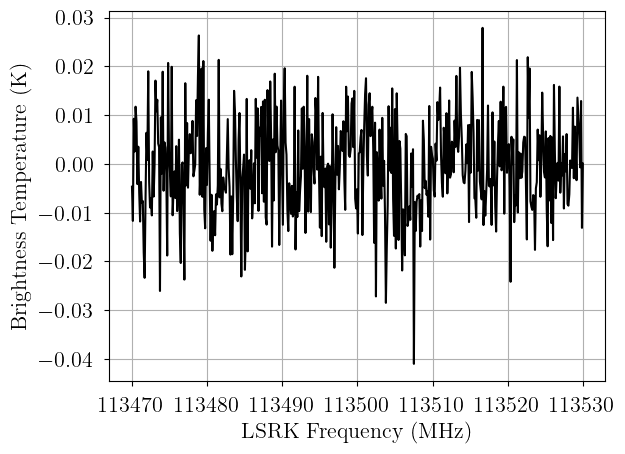

In [3]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.linspace(113470.0, 113530.0, 500) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.01 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

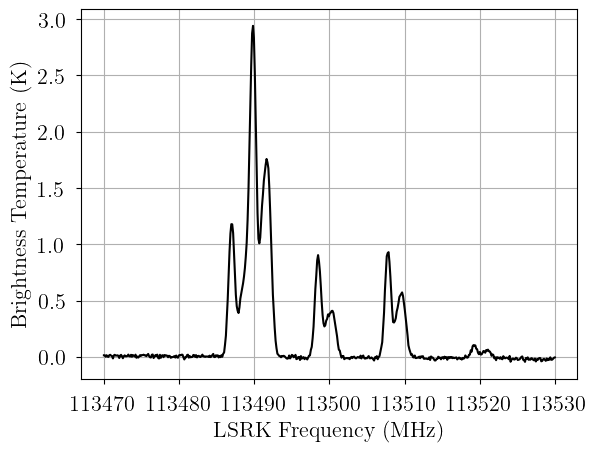

In [4]:
from bayes_cn_hfs import HFSAnomalyModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = HFSAnomalyModel(
    dummy_data,
    mol_data=mol_data_12CN,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 0.2], # mean and width of log10(N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_rms = 0.1, # width of spectral rms prior (K)
    prior_tex_anomaly = 1.0, # width of the hyperfine anomaly prior (K)
)
model.add_likelihood()

tex_anomaly = np.ones((len(mol_data_12CN['freq']), n_clouds))
for i, freq in enumerate(mol_data_12CN['freq']):
    if freq == 113499.643:
        tex_anomaly[i] = np.array([-5.0, -4.0, -3.0])
    if freq == 113508.934:
        tex_anomaly[i] = np.array([5.0, 4.0, 3.0])

sim_brightness = model.model.observation.eval({
    "log10_N": [14.0, 13.5, 14.2],
    "log10_tex": [1.0, 1.2, 1.1],
    "fwhm": [3.0, 2.0, 2.5],
    "velocity": [-2.0, 0.0, 3.0],
    "rms_observation": noise,
    "tex_anomaly": tex_anomaly,
    "baseline_observation_norm": [-0.5, -3.0, 2.0], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model Definition

In [6]:
# Initialize and define the model
model = HFSAnomalyModel(
    data,
    mol_data=mol_data_12CN,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 0.2], # mean and width of log10(N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_rms = 0.1, # width of spectral rms prior (K)
    prior_tex_anomaly = 1.0, # width of the hyperfine anomaly prior (K)
)
model.add_likelihood()

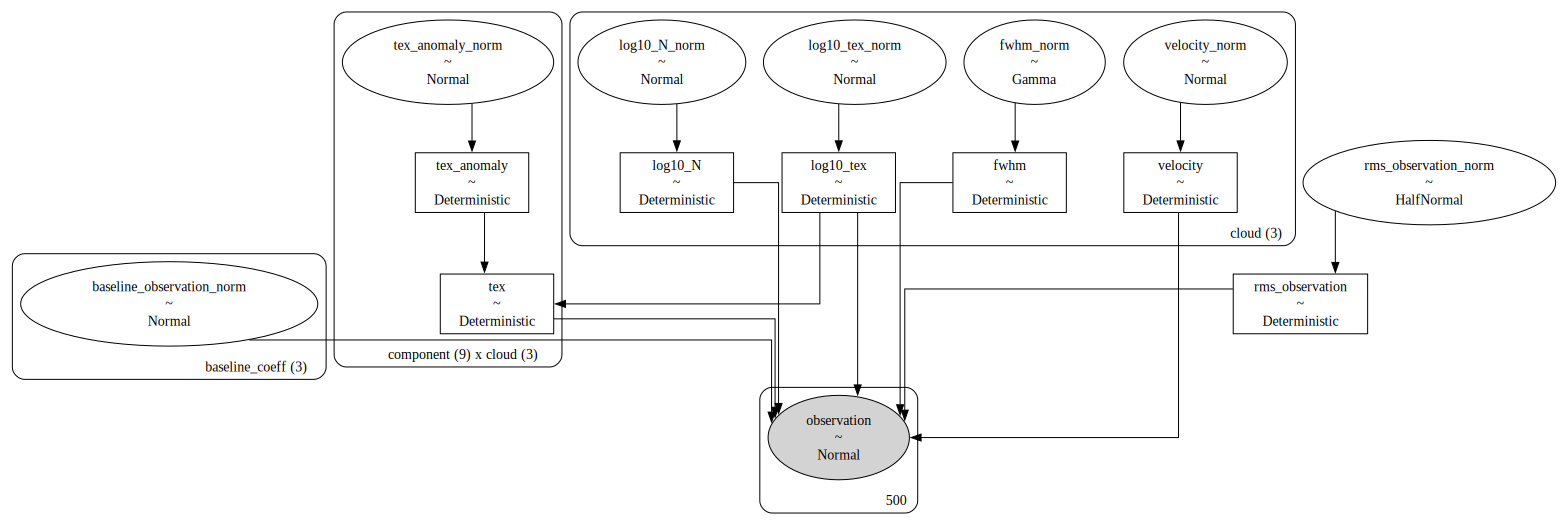

In [7]:
# Plot model graph
model.graph().render('hfs_anomaly_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, <constant>)
             log10_N_norm ~ Normal(0, 1)
           log10_tex_norm ~ Normal(0, 1)
                fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
     rms_observation_norm ~ HalfNormal(0, 1)
         tex_anomaly_norm ~ Normal(0, 1)
                  log10_N ~ Deterministic(f(log10_N_norm))
                log10_tex ~ Deterministic(f(log10_tex_norm))
                     fwhm ~ Deterministic(f(fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
          rms_observation ~ Deterministic(f(rms_observation_norm))
              tex_anomaly ~ Deterministic(f(tex_anomaly_norm))
                      tex ~ Deterministic(f(tex_anomaly_norm, log10_tex_norm))
              observation ~ Normal(f(baseline_observation_norm, tex_anomaly_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm), rms_observation)


Sampling: [baseline_observation_norm, fwhm_norm, log10_N_norm, log10_tex_norm, observation, rms_observation_norm, tex_anomaly_norm, velocity_norm]


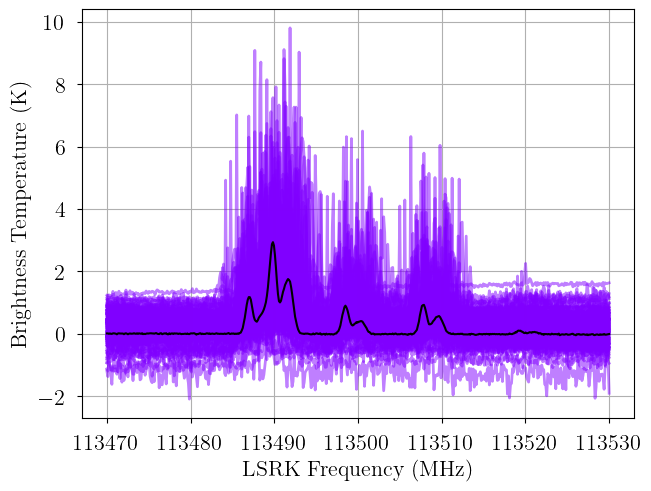

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5400
Interrupted at 5,399 [5%]: Average Loss = -92.301


Output()

Runtime: 0.53 minutes


In [11]:
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N[0],14.099,0.001,14.097,14.101,0.000,0.000,950.0,967.0,NaN
log10_N[1],13.935,0.002,13.931,13.938,0.000,0.000,944.0,941.0,NaN
log10_N[2],13.823,0.003,13.817,13.830,0.000,0.000,921.0,1021.0,NaN
log10_tex[0],1.006,0.011,0.986,1.027,0.000,0.000,996.0,944.0,NaN
log10_tex[1],0.902,0.006,0.890,0.914,0.000,0.000,1019.0,1021.0,NaN
log10_tex[2],0.974,0.027,0.920,1.019,0.001,0.001,950.0,843.0,NaN
fwhm[0],2.275,0.007,2.260,2.287,0.000,0.000,955.0,1060.0,NaN
fwhm[1],3.123,0.016,3.096,3.155,0.001,0.000,912.0,900.0,NaN
fwhm[2],5.167,0.046,5.083,5.257,0.001,0.001,1053.0,983.0,NaN
velocity[0],3.090,0.004,3.083,3.098,0.000,0.000,993.0,892.0,NaN


Sampling: [observation]


Output()

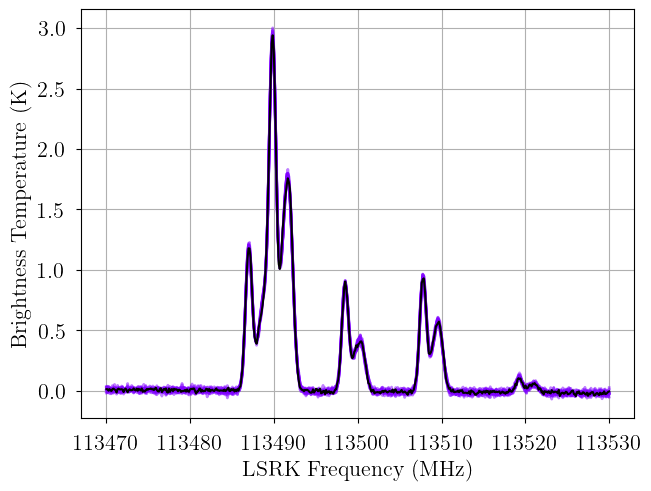

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5400
Interrupted at 5,399 [5%]: Average Loss = -92.301
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm, rms_observation_norm, tex_anomaly_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1198 seconds.


Adding log-likelihood to trace


Output()

Runtime: 20.95 minutes


In [14]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [15]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"], var_names=model.cloud_deterministics)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N[0],14.185,0.013,14.162,14.209,0.000,0.000,1974.0,2230.0,1.0
log10_N[1],14.011,0.012,13.990,14.035,0.000,0.000,1860.0,2003.0,1.0
log10_N[2],13.410,0.048,13.323,13.501,0.001,0.001,2183.0,2472.0,1.0
log10_tex[0],1.048,0.035,0.981,1.113,0.001,0.001,2140.0,2385.0,1.0
log10_tex[1],0.869,0.041,0.790,0.945,0.001,0.001,2158.0,2293.0,1.0
log10_tex[2],1.085,0.103,0.894,1.276,0.002,0.001,2721.0,2794.0,1.0
fwhm[0],2.478,0.012,2.457,2.502,0.000,0.000,2538.0,2557.0,1.0
fwhm[1],3.017,0.031,2.952,3.070,0.001,0.000,2301.0,2667.0,1.0
fwhm[2],1.928,0.058,1.818,2.036,0.001,0.001,2081.0,2508.0,1.0
velocity[0],2.997,0.003,2.991,3.004,0.000,0.000,3267.0,3141.0,1.0


Sampling: [observation]


Output()

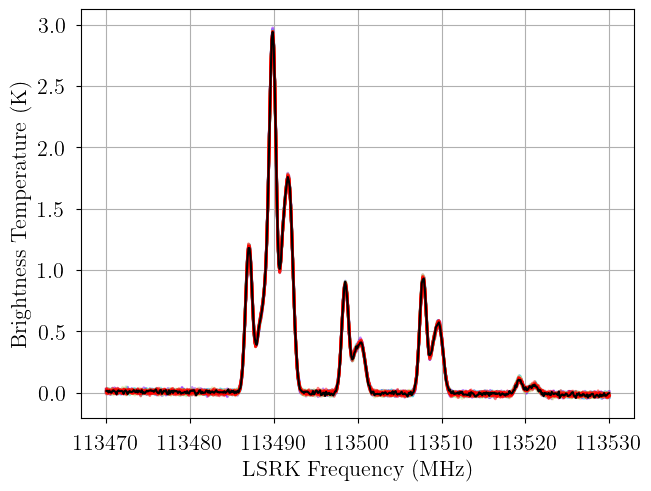

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

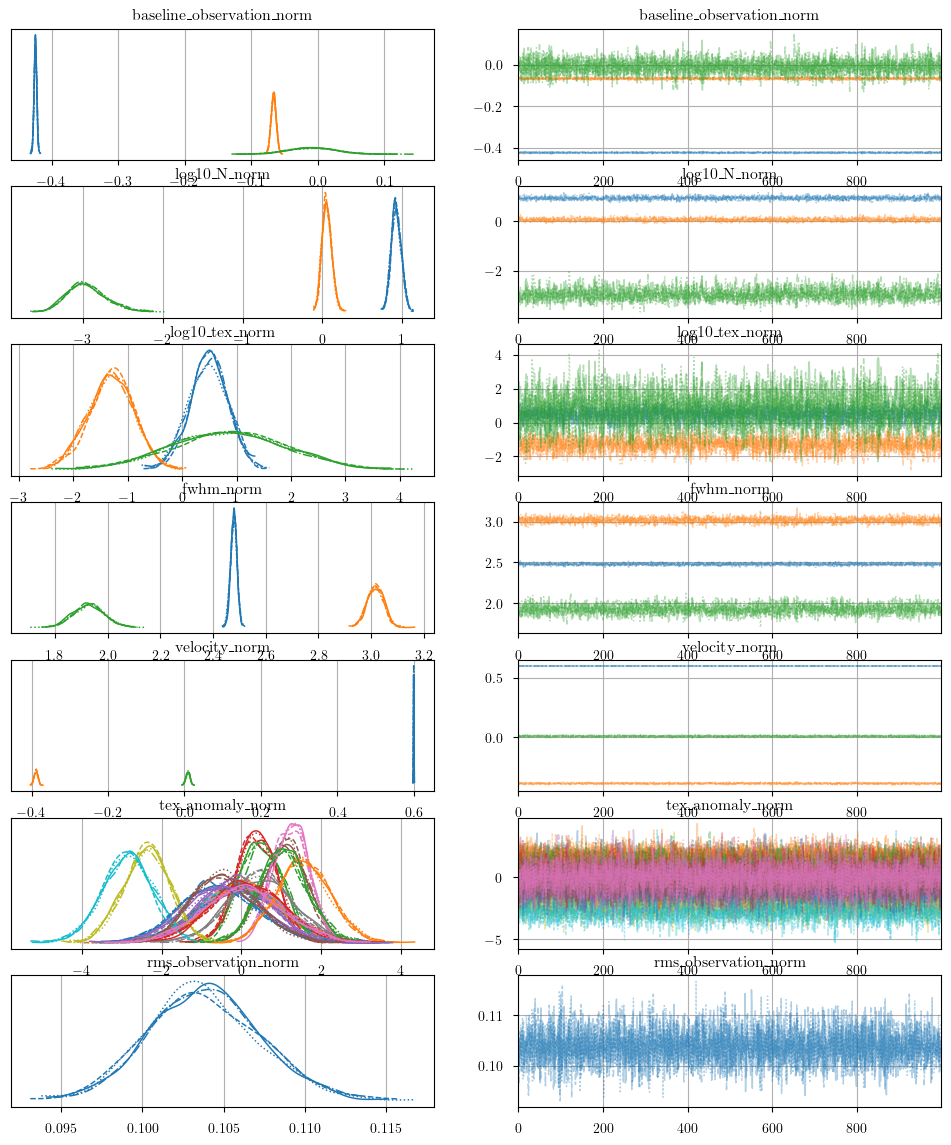

In [17]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.baseline_freeRVs + model.cloud_freeRVs + model.hyper_freeRVs)

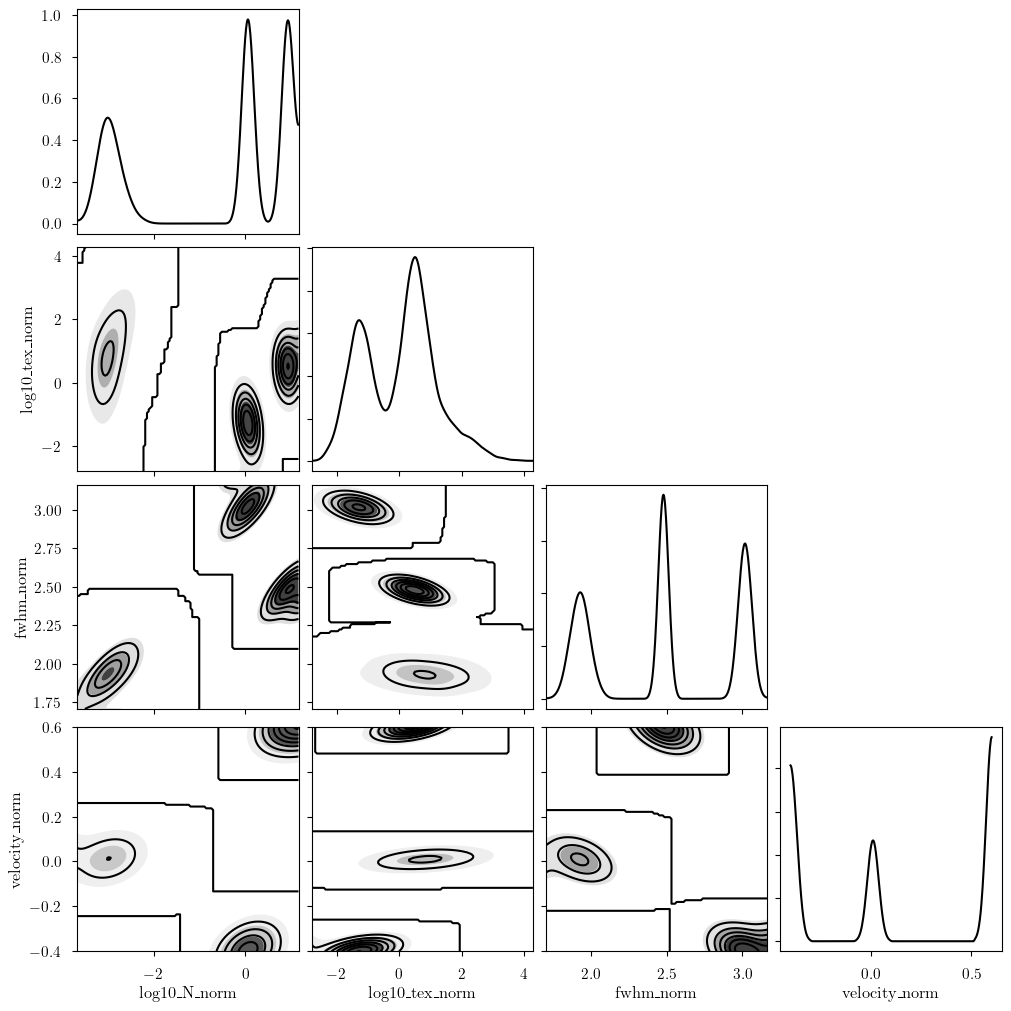

In [18]:
from bayes_spec.plots import plot_pair

var_names = [param for param in model.cloud_freeRVs if "tex_anomaly" not in param]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

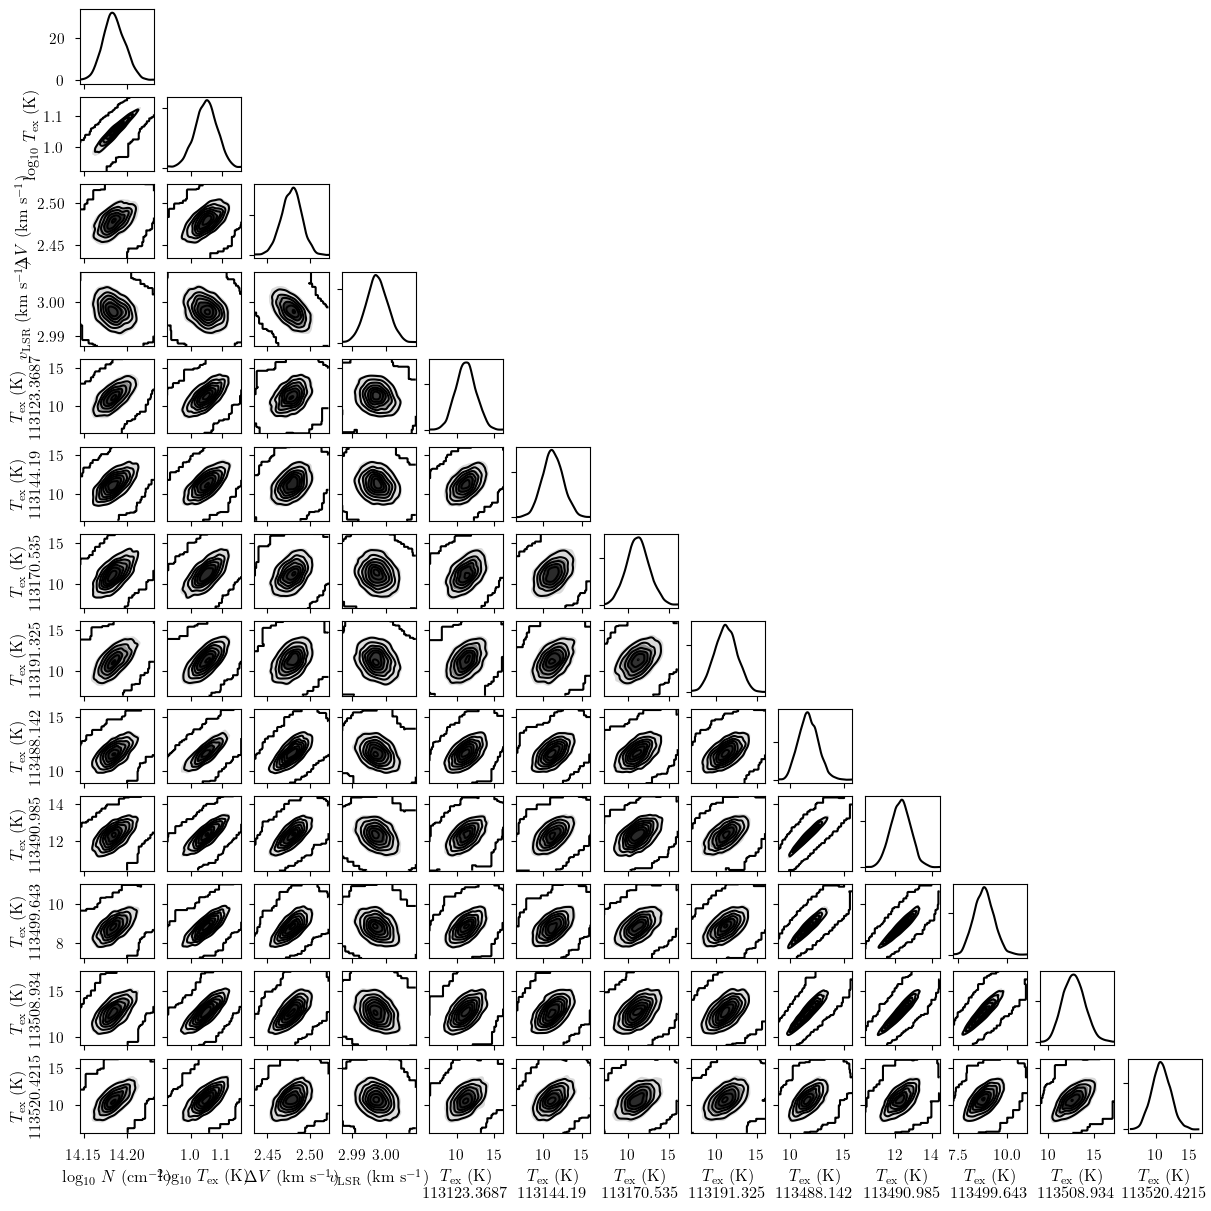

In [19]:
var_names = [param for param in model.cloud_deterministics if "tex_anomaly" not in param]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [20]:
point_stats = az.summary(model.trace.solution_0, model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -2883.181977909706


,mean,sd,hdi_16%,hdi_84%
log10_N[0],14.185,0.013,14.173,14.198
log10_N[1],14.011,0.012,13.997,14.021
log10_N[2],13.410,0.048,13.354,13.446
log10_tex[0],1.048,0.035,1.013,1.083
log10_tex[1],0.869,0.041,0.834,0.916
log10_tex[2],1.085,0.103,0.974,1.181
fwhm[0],2.478,0.012,2.468,2.492
fwhm[1],3.017,0.031,2.984,3.047
fwhm[2],1.928,0.058,1.876,1.990
velocity[0],2.997,0.003,2.994,3.000
